In [23]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

/Users/leonackermann/miniforge3/envs/iannwtf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
X_train.shape


170498071/170498071 [==============================] - 8s 0us/step


(50000, 32, 32, 3)

In [8]:
def preprocess()
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [26]:
train, test, info = tfds.load(
    'cifar10',
    split=["train","test"],
    as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
    with_info=True,
)


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 107.61 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 80.13 url/s] 


KeyboardInterrupt: 

In [13]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [14]:
def plot(X,y,index):            
    plt.figure(figsize=(15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

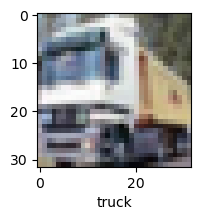

In [15]:
plot(X_train, y_train, 1)

In [21]:
# 2. write function to create the dataset that we want
def preprocess(data, batch_size):
    # image should be float
    data = data.map(lambda x, t: (tf.cast(x, float), t))
    
    # image should be flattened
    data = data.map(lambda x, t: x, (tf.reshape(t, (-1,))))
    
    # image vector will here have values between -1 and 1
    data = data.map(lambda x,t: ((x/128.)-1., t))
    
    # batch the dataset
    data = data.batch(batch_size)
    # prefetch
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

train_ds1 = preprocess((X_train, y_train), batch_size=32) #train_ds.apply(preprocess)
val_ds1 = preprocess((X_test, y_test), batch_size=32) #val_ds.apply(preprocess)


AttributeError: 'tuple' object has no attribute 'map'

In [18]:
class BinaryModel(tf.keras.Model):

    # 1. constructor
    def __init__(self):
        super().__init__()
        # inherit functionality from parent class

        # optimizer, loss function and metrics
        self.metrics_list = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"), tf.keras.metrics.Mean(name="loss")]
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

        # layers to encode the images (both layers used for both images)
        self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=(32, 32, 3))
        self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)


        self.dense1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        
        self.dense3 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        
        self.out_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
        
    # 2. call method (forward computation)
    def call(self, image, training=False):

        x = image
        for layer in self.layers:
            x = layer(x)

        return x

        img1_x = self.dense1(img1)
        img1_x = self.dense2(img1_x)
        
        img2_x = self.dense1(img2)
        img2_x = self.dense2(img2_x)
        
        combined_x = tf.concat([img1_x, img2_x ], axis=1)
        combined_x = self.dense3(combined_x)
        return self.out_layer(combined_x)

    # 3. metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model

    # 4. reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    # 5. train step method
    @tf.function
    def train_step(self, data):
        img1, img2, label = data
        
        with tf.GradientTape() as tape:
            output = self((img1, img2), training=True)
            loss = self.loss_function(label, output)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)
        
        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}

    # 6. test_step method
    @tf.function
    def test_step(self, data):
        img1, img2, label = data
        # same as train step (without parameter updates)
        output = self((img1, img2), training=False)
        loss = self.loss_function(label, output)
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)
        
        return {m.name : m.result() for m in self.metrics}